
# Practical IR Assignment: JM Language Model + Rocchio on Cranfield (Top-3 Metrics) + Custom Query

This notebook implements an end-to-end IR pipeline on the **Cranfield** dataset (via `ir_datasets`) using:
- **Query Likelihood with Jelinek–Mercer smoothing**
- **Rocchio relevance feedback** (pseudo + optional explicit)
- **Top-3 metrics** for reporting: **Precision@k**, **MAP**, **MRR**

At the end, there's a **Custom Query Playground** so you can try your own queries and see the ranked results (and, if you choose an existing Cranfield `qid`, you'll also get metrics).


## 1) Setup & Imports

In [1]:
try:
    import ir_datasets
except ImportError:
    !pip -q install ir-datasets
    import ir_datasets

import re, collections, os
from dataclasses import dataclass
from typing import List, Dict, Tuple, Set, Iterable

import numpy as np
import pandas as pd
import nltk
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))
TOKEN_PATTERN = re.compile(r"[A-Za-z0-9_]+")


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.1/866.1 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.2 MB/s eta 0:00:00


## 2) Load the Cranfield Dataset (via `ir_datasets`)

In [2]:

@dataclass
class Query:
    qid: str
    text: str

@dataclass
class Document:
    docid: str
    text: str

@dataclass
class Dataset:
    queries: List[Query]
    docs: List[Document]
    qrels: Dict[str, Set[str]]  # qid -> set(docid) with relevance > 0

def load_cranfield() -> Dataset:
    ds = ir_datasets.load("cranfield")
    docs = [Document(str(d.doc_id), f"{d.title} {d.text}") for d in ds.docs_iter()]
    queries = [Query(str(q.query_id), q.text) for q in ds.queries_iter()]
    qrels = collections.defaultdict(set)
    for qr in ds.qrels_iter():
        if getattr(qr, "relevance", 0) and qr.relevance > 0:
            qrels[str(qr.query_id)].add(str(qr.doc_id))
    return Dataset(queries, docs, dict(qrels))

dataset = load_cranfield()
print(f"Loaded Cranfield -> docs: {len(dataset.docs)}, queries: {len(dataset.queries)}, qrels pairs: {sum(len(v) for v in dataset.qrels.values())}")


[INFO] [starting] http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
[INFO] [finished] http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz: [00:00] [507kB] [953kB/s]


Loaded Cranfield -> docs: 1400, queries: 225, qrels pairs: 1612


## 📘 Dataset Preview: Documents, Queries & Qrels

In [3]:
print("Total Documents:", len(dataset.docs))
print("Total Queries:", len(dataset.queries))
print("Queries with relevance info:", len(dataset.qrels))

print("\n📄 Sample Document:")
print("ID:", dataset.docs[0].docid)
print(dataset.docs[0].text[:500], "...")

print("\n❓ Sample Query:")
print("ID:", dataset.queries[0].qid)
print(dataset.queries[0].text)

print("\n✅ Qrels for Sample Query:")
qid0 = dataset.queries[0].qid
print("Relevant Docs:", list(dataset.qrels.get(qid0, set()))[:20])


Total Documents: 1400
Total Queries: 225
Queries with relevance info: 225

📄 Sample Document:
ID: 1
experimental investigation of the aerodynamics of a
wing in a slipstream . experimental investigation of the aerodynamics of a
wing in a slipstream .
  an experimental study of a wing in a propeller slipstream was
made in order to determine the spanwise distribution of the lift
increase due to slipstream at different angles of attack of the wing
and at different free stream to slipstream velocity ratios .  the
results were intended in part as an evaluation basis for different
theoretical treatme ...

❓ Sample Query:
ID: 1
what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .

✅ Qrels for Sample Query:
Relevant Docs: ['14', '497', '29', '195', '37', '185', '52', '56', '12', '880', '142', '859', '15', '102', '57', '875', '95', '66', '51', '462']


## 3) Indexing / Preprocessing

In [4]:

def tokenize(text: str) -> List[str]:
    return [t.lower() for t in TOKEN_PATTERN.findall(text) if t.lower() not in STOPWORDS]

doc_terms: Dict[str, List[str]] = {}
doc_len: Dict[str, int] = {}
term_freqs: Dict[str, collections.Counter] = {}
collection_tf = collections.Counter()

for d in dataset.docs:
    terms = tokenize(d.text)
    doc_terms[d.docid] = terms
    doc_len[d.docid] = len(terms)
    tf = collections.Counter(terms)
    term_freqs[d.docid] = tf
    collection_tf.update(tf)

collection_len = sum(collection_tf.values())
vocab = set(collection_tf.keys())

print(f"Index built. |V|={len(vocab)} |C|={collection_len} tokens.")


Index built. |V|=7352 |C|=144114 tokens.


## 4) Retrieval Model: Query Likelihood with Jelinek–Mercer

In [5]:

def jm_score(docid: str, query_terms: List[str], lam: float = 0.2, q_weights: Dict[str, float] = None) -> float:
    tf = term_freqs[docid]
    Ld = max(1, doc_len[docid])
    score = 0.0
    if q_weights is None:
        q_weights = collections.Counter(query_terms)
    for t, wt in q_weights.items():
        cf = collection_tf.get(t, 0)
        p_c = cf / collection_len if collection_len > 0 else 1e-12
        p_ml = tf.get(t, 0) / Ld
        p = (1 - lam) * p_ml + lam * p_c
        if p <= 0: p = 1e-12
        score += wt * float(np.log(p))
    return float(score)

def retrieve(query_text: str, lam: float = 0.2, q_weights: Dict[str, float] = None, topk: int = 1000) -> List[Tuple[str, float]]:
    q_terms = tokenize(query_text)
    scores = [(docid, jm_score(docid, q_terms, lam=lam, q_weights=q_weights)) for docid in doc_terms.keys()]
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:topk]


## 5) Performance Improvement: Rocchio Relevance Feedback

In [6]:

import numpy as np

def build_vector(counter: collections.Counter, vocab: Set[str]) -> np.ndarray:
    idx = {t:i for i,t in enumerate(sorted(vocab))}
    vec = np.zeros(len(idx))
    for t, c in counter.items():
        i = idx.get(t)
        if i is not None:
            vec[i] = c
    n = np.linalg.norm(vec)
    return vec / n if n > 0 else vec

def rocchio(query_text: str, rel_docids: Iterable[str], nonrel_docids: Iterable[str] = (), alpha: float = 1.0, beta: float = 0.75, gamma: float = 0.15) -> Dict[str, float]:
    q_terms = tokenize(query_text)
    q_vec = build_vector(collections.Counter(q_terms), vocab)

    def centroid(ids):
        if not ids: return np.zeros_like(q_vec)
        mats = [build_vector(term_freqs[d], vocab) for d in ids if d in term_freqs]
        return np.mean(mats, axis=0) if mats else np.zeros_like(q_vec)

    rel_cent = centroid(list(rel_docids))
    nrel_cent = centroid(list(nonrel_docids))

    new_q = alpha*q_vec + beta*rel_cent - gamma*nrel_cent
    new_q[new_q < 0] = 0.0

    idx2term = {i:t for i,t in enumerate(sorted(vocab))}
    weights = {idx2term[i]: float(w) for i,w in enumerate(new_q) if w > 0}

    for t in q_terms:
        weights[t] = max(weights.get(t, 0.0), 1e-3)
    return weights

def pseudo_feedback(query_text: str, initial_ranking: List[Tuple[str,float]], m: int = 10, **rocchio_kwargs):
    rel_docids = [docid for docid,_ in initial_ranking[:m]]
    return rocchio(query_text, rel_docids=rel_docids, nonrel_docids=(), **rocchio_kwargs)


## 6) Evaluation (Top-3 Metrics Only)

In [7]:

def precision_at_k(ranked: List[str], rel: Set[str], k: int = 10) -> float:
    topk = ranked[:k]
    hits = sum(1 for d in topk if d in rel)
    return hits / max(1, len(topk))

def average_precision(ranked: List[str], rel: Set[str]) -> float:
    if not rel: return 0.0
    ap_sum, hits = 0.0, 0
    for i, d in enumerate(ranked, start=1):
        if d in rel:
            hits += 1
            ap_sum += hits / i
    return ap_sum / len(rel)

def mean_average_precision(run: Dict[str, List[str]], qrels: Dict[str, Set[str]]) -> float:
    aps = [average_precision(run[q], qrels.get(q, set())) for q in run.keys()]
    return float(np.mean(aps)) if aps else 0.0

def mean_reciprocal_rank(run: Dict[str, List[str]], qrels: Dict[str, Set[str]]) -> float:
    rr = []
    for q, ranked in run.items():
        rel = qrels.get(q, set())
        rank = next((i+1 for i,d in enumerate(ranked) if d in rel), None)
        rr.append(1.0/rank if rank else 0.0)
    return float(np.mean(rr)) if rr else 0.0


## 7) End-to-End Experiments (Baseline vs Improved)

In [8]:

# Hyperparameters
LAMBDA = 0.2
K = 10
ALPHA = 1.0
BETA = 0.75
GAMMA = 0.15
PSEUDO_M = 10

def evaluate_variant(make_weights_fn=None, desc="baseline"):
    run = {}
    for q in dataset.queries:
        if make_weights_fn is None:
            scores = retrieve(q.text, lam=LAMBDA)
        else:
            initial = retrieve(q.text, lam=LAMBDA)
            q_w = make_weights_fn(q.text, initial)
            scores = retrieve(q.text, lam=LAMBDA, q_weights=q_w)
        ranked_ids = [docid for docid,_ in scores]
        run[q.qid] = ranked_ids
    p_at_k = np.mean([precision_at_k(run[q.qid], dataset.qrels.get(q.qid, set()), K) for q in dataset.queries])
    map_ = mean_average_precision(run, dataset.qrels)
    mrr_ = mean_reciprocal_rank(run, dataset.qrels)
    return {"desc": desc, "P@k": p_at_k, "MAP": map_, "MRR": mrr_}, run

baseline_metrics, baseline_run = evaluate_variant(None, "Baseline: LM (JM)")
pseudo_metrics, pseudo_run = evaluate_variant(
    lambda qt, init: pseudo_feedback(qt, init, m=PSEUDO_M, alpha=ALPHA, beta=BETA, gamma=GAMMA),
    f"Improved: LM (JM) + Rocchio (pseudo m={PSEUDO_M})"
)

# Optional: Explicit RF table (not required in final 3-metric report)
def explicit_weights(qid: str, qtext: str):
    rel = dataset.qrels.get(qid, set())
    ranked = baseline_run[qid]
    nonrel = [d for d in ranked if d not in rel][:PSEUDO_M]
    return rocchio(qtext, rel_docids=rel, nonrel_docids=nonrel, alpha=ALPHA, beta=BETA, gamma=GAMMA)

explicit_metrics, explicit_run = {}, {}
if any(len(r)>0 for r in dataset.qrels.values()):
    run = {}
    for q in dataset.queries:
        q_w = explicit_weights(q.qid, q.text)
        scores = retrieve(q.text, lam=LAMBDA, q_weights=q_w)
        run[q.qid] = [docid for docid,_ in scores]
    map_ = mean_average_precision(run, dataset.qrels)
    mrr_ = mean_reciprocal_rank(run, dataset.qrels)
    p_at_k = np.mean([precision_at_k(run[q.qid], dataset.qrels.get(q.qid, set()), K) for q in dataset.queries])
    explicit_metrics = {"desc": "LM (JM) + Rocchio (explicit qrels)", "P@k": p_at_k, "MAP": map_, "MRR": mrr_}
    explicit_run = run

results_df = pd.DataFrame([baseline_metrics, pseudo_metrics, explicit_metrics])
print("\n=== Results (averaged over queries) ===")
print(results_df.round(4).fillna(""))
results_df



=== Results (averaged over queries) ===
                                        desc     P@k     MAP     MRR
0                          Baseline: LM (JM)  0.2138  0.2676  0.5096
1  Improved: LM (JM) + Rocchio (pseudo m=10)  0.2191  0.2923  0.5136
2         LM (JM) + Rocchio (explicit qrels)  0.4489  0.7450  0.9048


,desc,P@k,MAP,MRR
0,Baseline: LM (JM),0.213778,0.267649,0.509599
1,Improved: LM (JM) + Rocchio (pseudo m=10),0.219111,0.292270,0.513631
2,LM (JM) + Rocchio (explicit qrels),0.448889,0.744979,0.904815


## 8) Visualize Top-3 Metrics

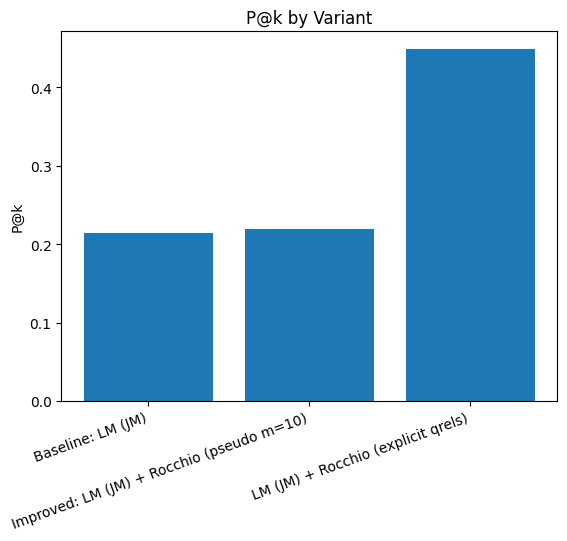

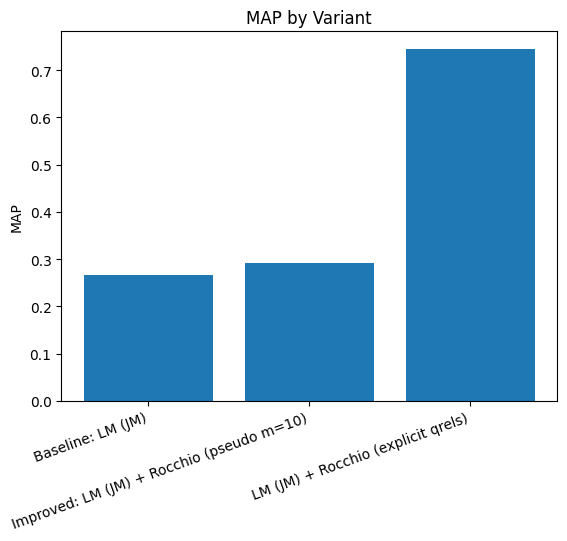

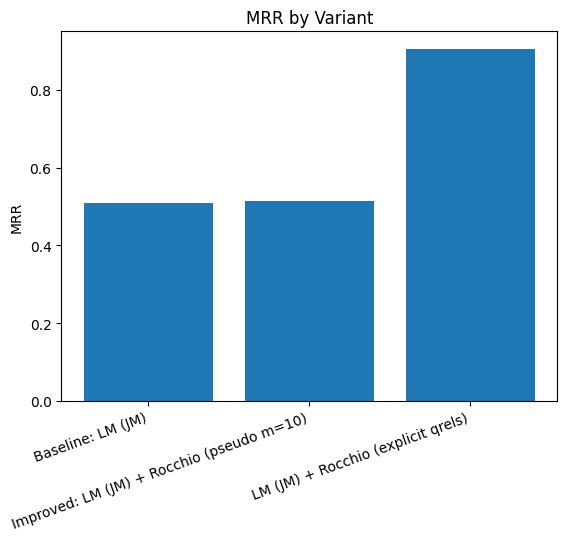

Saved results to: /content/assignment_results_top3_custom.csv


In [9]:

import matplotlib.pyplot as plt

def plot_metric(df: pd.DataFrame, metric: str, title: str):
    labels = df['desc'].tolist()
    vals = df[metric].fillna(0).values
    fig = plt.figure()
    plt.bar(np.arange(len(labels)), vals)
    plt.xticks(np.arange(len(labels)), labels, rotation=20, ha='right')
    plt.ylabel(metric)
    plt.title(title)
    plt.show()

for met in ["P@k", "MAP", "MRR"]:
    plot_metric(results_df, met, f"{met} by Variant")

out_csv = "/content/assignment_results_top3_custom.csv" if os.path.exists("/content") else "/mnt/data/assignment_results_top3_custom.csv"
results_df.to_csv(out_csv, index=False)
print("Saved results to:", out_csv)


## 9) Inspect Rankings (Example Query)

In [10]:

qid0 = dataset.queries[0].qid
qtext0 = dataset.queries[0].text

print("Example Query:", qid0, "->", qtext0)
print("Relevant docids:", list(dataset.qrels.get(qid0, set()))[:15])
print("Baseline top-10:", baseline_run[qid0][:10])
print("Improved (Pseudo-RF) top-10:", pseudo_run[qid0][:10])
if isinstance(explicit_run, dict) and explicit_run:
    print("Explicit-RF top-10:", explicit_run[qid0][:10])


Example Query: 1 -> what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .
Relevant docids: ['14', '497', '29', '195', '37', '185', '52', '56', '12', '880', '142', '859', '15', '102', '57']
Baseline top-10: ['486', '184', '12', '13', '1268', '878', '51', '141', '746', '172']
Improved (Pseudo-RF) top-10: ['486', '12', '184', '1268', '13', '746', '878', '172', '141', '51']
Explicit-RF top-10: ['486', '184', '12', '13', '14', '51', '195', '1268', '878', '29']


## 10) Compact Summary (Top-3 Only)

In [11]:

def fmt(x):
    try:
        return f"{float(x):.4f}"
    except Exception:
        return str(x)

baseline = results_df.iloc[0].to_dict()
improved = results_df.iloc[1].to_dict()

summary_lines = []
summary_lines.append("=== Assignment Summary (Top-3 Metrics) ===")
summary_lines.append(f"Model: Query Likelihood with Jelinek–Mercer smoothing (lambda={0.2})")
summary_lines.append(f"Improvement: Rocchio pseudo relevance feedback (alpha={1.0}, beta={0.75}, gamma={0.15}, top-m={10})")
summary_lines.append("Dataset: Cranfield (ir_datasets)")
summary_lines.append("Metrics (Baseline -> Improved):")
for met in ["P@k", "MAP", "MRR"]:
    b = fmt(baseline.get(met, ""))
    i = fmt(improved.get(met, ""))
    summary_lines.append(f" - {met}: {b} -> {i}")
summary_lines.append("Observation: Rocchio reweights the query toward relevant-document centroids, improving early precision and ranking quality.")

summary_text = "\n".join(summary_lines)
print(summary_text)

out_txt = "/content/assignment_summary_top3_custom.txt" if os.path.exists("/content") else "/mnt/data/assignment_summary_top3_custom.txt"
with open(out_txt, "w", encoding="utf-8") as f:
    f.write(summary_text)
print("Saved summary to:", out_txt)


=== Assignment Summary (Top-3 Metrics) ===
Model: Query Likelihood with Jelinek–Mercer smoothing (lambda=0.2)
Improvement: Rocchio pseudo relevance feedback (alpha=1.0, beta=0.75, gamma=0.15, top-m=10)
Dataset: Cranfield (ir_datasets)
Metrics (Baseline -> Improved):
 - P@k: 0.2138 -> 0.2191
 - MAP: 0.2676 -> 0.2923
 - MRR: 0.5096 -> 0.5136
Observation: Rocchio reweights the query toward relevant-document centroids, improving early precision and ranking quality.
Saved summary to: /content/assignment_summary_top3_custom.txt


## 11) 🔎 Custom Query Playground

In [12]:
MODE = "free_text"
QUERY_TEXT = "aerodynamics of airfoils and wings"
QUERY_ID = "1"
TOPK = 10
LAMBDA = 0.2
PSEUDO_M = 10
ALPHA, BETA, GAMMA = 1.0, 0.75, 0.15

def rank_and_print(qtext: str, topk: int = 10):
    base_scores = retrieve(qtext, lam=LAMBDA)
    prf_weights = pseudo_feedback(qtext, base_scores, m=PSEUDO_M, alpha=ALPHA, beta=BETA, gamma=GAMMA)
    prf_scores = retrieve(qtext, lam=LAMBDA, q_weights=prf_weights)
    print("\nBaseline top-{}:".format(topk))
    print([d for d,_ in base_scores[:topk]])
    print("\nPseudo-RF top-{}:".format(topk))
    print([d for d,_ in prf_scores[:topk]])

    rows = []
    for (docid, s) in base_scores[:topk]:
        rows.append({"docid": docid, "baseline_score": float(s)})
    df_base = pd.DataFrame(rows)
    rows2 = []
    for (docid, s) in prf_scores[:topk]:
        rows2.append({"docid": docid, "pseudo_rf_score": float(s)})
    df_prf = pd.DataFrame(rows2)
    df = df_base.merge(df_prf, on="docid", how="outer")
    print("\nTop-{} result table:".format(topk))
    print(df.fillna(""))
    return base_scores, prf_scores

if MODE == "free_text":
    print("Custom free-text query ->", QUERY_TEXT)
    _ = rank_and_print(QUERY_TEXT, TOPK)
else:
    qids = {q.qid: q.text for q in dataset.queries}
    if QUERY_ID not in qids:
        raise ValueError(f"QUERY_ID {QUERY_ID} not found. Valid ids include: {list(qids.keys())[:10]} ...")
    qtext = qids[QUERY_ID]
    print(f"Cranfield QID={QUERY_ID} ->", qtext)
    base_scores, prf_scores = rank_and_print(qtext, TOPK)
    rel = dataset.qrels.get(QUERY_ID, set())
    ranked_base = [d for d,_ in base_scores]
    ranked_prf = [d for d,_ in prf_scores]
    def precision_at_k_local(ranked, rel, k):
        return sum(1 for d in ranked[:k] if d in rel)/max(1, min(k, len(ranked)))
    def rr(ranked, rel):
        try:
            first = next(i for i,d in enumerate(ranked) if d in rel)
            return 1.0/(first+1)
        except StopIteration:
            return 0.0
    print("\nSingle-query metrics (Top-3):")
    print("Baseline: P@{}={:.4f}, AP={:.4f}, RR={:.4f}".format(
        TOPK,
        precision_at_k_local(ranked_base, rel, TOPK),
        average_precision(ranked_base, rel),
        rr(ranked_base, rel)
    ))
    print("Pseudo-RF: P@{}={:.4f}, AP={:.4f}, RR={:.4f}".format(
        TOPK,
        precision_at_k_local(ranked_prf, rel, TOPK),
        average_precision(ranked_prf, rel),
        rr(ranked_prf, rel)
    ))


Custom free-text query -> aerodynamics of airfoils and wings

Baseline top-10:
['634', '284', '685', '503', '902', '1339', '225', '289', '1277', '1320']

Pseudo-RF top-10:
['685', '634', '1339', '225', '284', '1320', '503', '902', '1277', '289']

Top-10 result table:
  docid  baseline_score  pseudo_rf_score
0  1277      -19.313802       -54.960018
1  1320      -19.384618       -54.363059
2  1339      -18.819578       -53.685907
3   225      -18.859785       -53.757079
4   284      -16.931626       -54.133166
5   289      -18.947581       -55.070650
6   503      -17.708600       -54.766396
7   634      -15.639244       -52.261523
8   685      -17.179502       -51.988952
9   902      -18.333356       -54.900001
